# Single cell analysis

In [1]:
import numpy as np
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation
import glob
import os
from pathlib import Path
from matplotlib import pyplot as plt
import sys

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)


def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier


def print_file(filename):
    with open(filename, "r") as f:
        print(f.readlines())

In [2]:
os.environ["HLBI_PIPE_BASEDIR"] = (
    "/lustre/scratch126/cellgen/team298/vm11/PROJECTS/PIPELINE/Haniffa-utils/"
)

In [3]:
!cat scanpy_rna_config.py

gex_only = True
sim_doublet_ratio = 5
min_cells_cutoff = 50  # min number of cells a gene is present for it to be realised


In [4]:
# Importing config file
# %reload_ext scanpy_rna_config
# if os.path.exists("scanpy_rna_config.py"):
#    print("Reading user config file")
#    from scanpy_rna_config import *
# else:
#    print("Reading global config file")
#    sys.path.append(os.path.join(os.environ['HLBI_PIPE_BASEDIR'], 'bin', 'nb'))
#    from scanpy_rna_config import *

## User input values


In [5]:
gex_only = True
pct_mit_cutoff = 20
min_cells_cutoff = 50
min_genes_cutoff = 100
sim_doublet_ratio = 5
target_sum = 10000
n_top_genes = 2000
n_comps = 50  # pca
n_pcs = 50  # kNN
resolution = 1  # leiden
min_dist = 0.5  # UMAP
spread = 1  # UMAP

In [6]:
samples_database = "/lustre/scratch126/cellgen/team298/sample_data/"
# sample_n = "Apr24_chimeroid_d97_03A-BFP_HCA_SkO15052460"
# sample_folder="/lustre/scratch126/cellgen/team298/sample_data/BK23-SKI-27-FT-1b_mG_rBCN14655446/processed_sanger"
sample_name = "BK23-SKI-27-FT-1b_mG"
sample_id = "HCA_SkO15052460"
cellranger_folder = "cellranger-dff"

In [7]:
file_to_read = "filtered_feature_bc_matrix.h5"

## Reading file

In [ ]:
# Read file
#outpt_folder = os.path.join(samples_database, "rna_scanpy", sample_id)
# outpt_folder =  os.path.join("test", sample_name)
outpt_folder=os.path.join(samples_database, "rna_scanpy")
os.makedirs(outpt_folder, exist_ok=True)
print(samples_database)
print(sample_id)
print(cellranger_folder)
cranger_folder=os.path.join(samples_database, sample_id, cellranger_folder)
print(cranger_folder)
x = list(
    Path(cranger_folder).rglob(
        "filtered_feature_bc_matrix.h5"
    )
)
print(x)
readfilename = x[0]
readfilename
adata = sc.read_10x_h5(readfilename, gex_only=gex_only)
adata.var_names_make_unique()
adata

In [18]:
adata.obs.index = list(
    map(lambda x: str.split(x, "-")[0] + "_" + sample_name, list(adata.obs.index))
)
adata.obs["sample_name"] = sample_name

In [19]:
adata.obs.head()

,sample_name
AAACAGCCACAATTAC_BK23-SKI-27-FT-1b_mG_rBCN14655446,BK23-SKI-27-FT-1b_mG_rBCN14655446
AAACATGCACCTGCCT_BK23-SKI-27-FT-1b_mG_rBCN14655446,BK23-SKI-27-FT-1b_mG_rBCN14655446
AAACATGCAGCGCTTG_BK23-SKI-27-FT-1b_mG_rBCN14655446,BK23-SKI-27-FT-1b_mG_rBCN14655446
AAACATGCATCCCTCA_BK23-SKI-27-FT-1b_mG_rBCN14655446,BK23-SKI-27-FT-1b_mG_rBCN14655446
AAACCAACAAGTGTTT_BK23-SKI-27-FT-1b_mG_rBCN14655446,BK23-SKI-27-FT-1b_mG_rBCN14655446


## Remove bad quality cells and low value genes
* Mit
* Genes in less cells
* Remove cells with less genes

In [13]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [14]:
sc.pp.calculate_qc_metrics(adata, inplace=True)
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)

In [15]:
min_cells = np.round(adata.shape[0] * 0.005)
if min_cells > min_cells_cutoff:
    min_cells = min_cells_cutoff
min_counts = 1

In [16]:
min_genes = np.round(adata.shape[0] * 0.005)
if min_genes > min_genes_cutoff:
    min_genes = min_genes_cutoff
min_counts = 1

In [18]:
sc.pp.filter_genes(adata, min_cells=min_cells_cutoff)
sc.pp.filter_cells(adata, min_genes=min_genes_cutoff)

/home/jovyan/my-conda-envs/singlecell/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


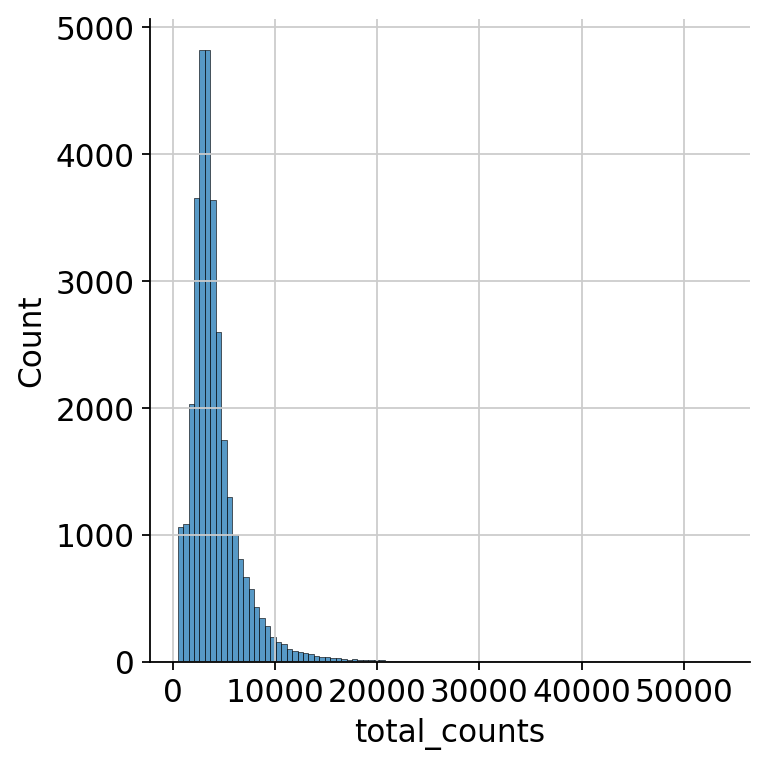

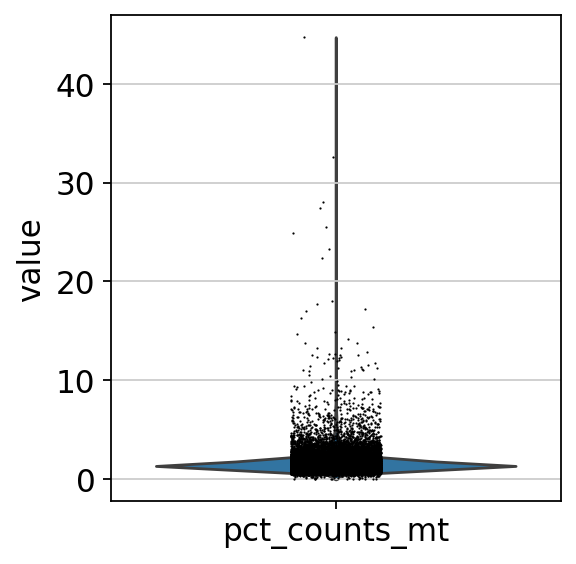

/home/jovyan/my-conda-envs/singlecell/lib/python3.10/site-packages/scanpy/plotting/_utils.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


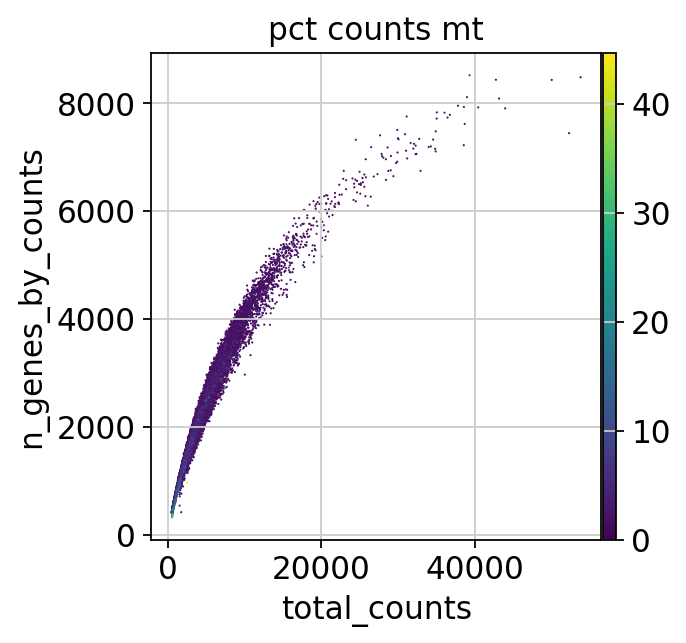

In [19]:
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [20]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

outlier
False    30992
True      1098
Name: count, dtype: int64

In [21]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 5) | (
    adata.obs["pct_counts_mt"] > pct_mit_cutoff
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    30571
True      1519
Name: count, dtype: int64

In [22]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 32090
Number of cells after filtering of low quality cells: 29739


/home/jovyan/my-conda-envs/singlecell/lib/python3.10/site-packages/scanpy/plotting/_utils.py:716: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


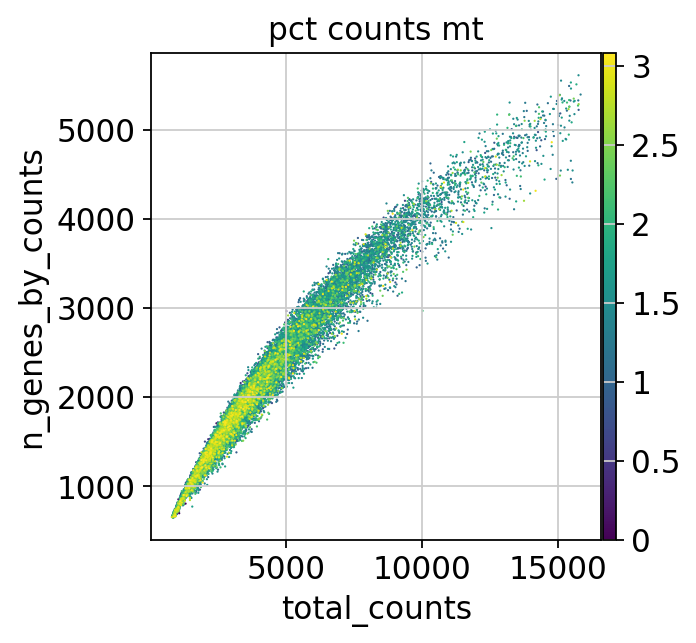

In [23]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Removal of doublets using scrublet

In [24]:
print("Sim doublet ratio:", sim_doublet_ratio)
threshold = 0.7
sc.external.pp.scrublet(adata, sim_doublet_ratio=sim_doublet_ratio, threshold=threshold)
# sc.pp.scrublet(adata)
# sc.external.pp.scrublet(adata)

Sim doublet ratio: 5


/home/jovyan/my-conda-envs/singlecell/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]
/home/jovyan/my-conda-envs/singlecell/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.10
Detected doublet rate = 16.6%
Estimated detectable doublet fraction = 76.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 21.9%


/home/jovyan/my-conda-envs/singlecell/lib/python3.10/site-packages/scanpy/external/pl.py:419: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for idx, (batch_key, sub_obs) in enumerate(adata.obs.groupby(batches)):


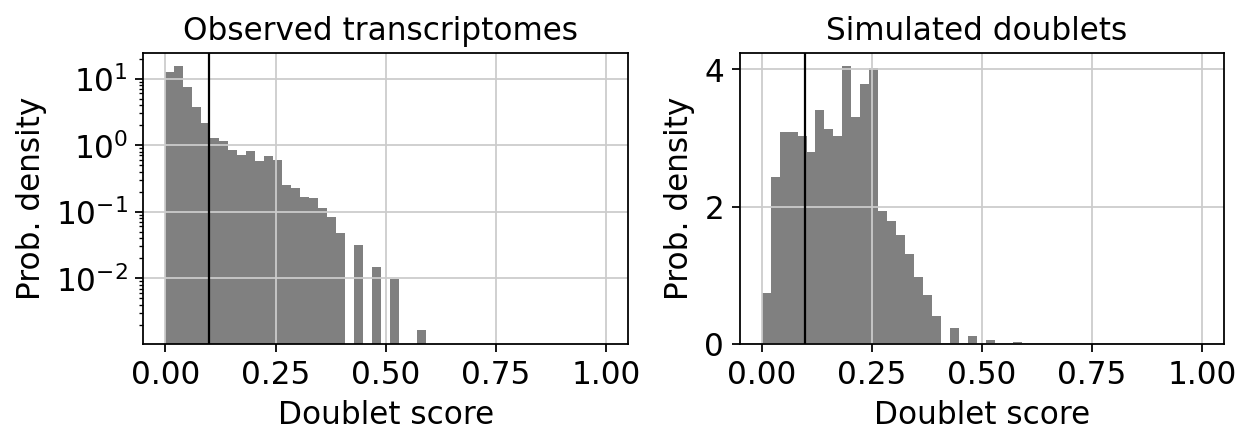

In [25]:
# sc.external.pl.scrublet_score_distribution(adata)

In [30]:
# adata.obs.predicted_doublet.value_counts()

predicted_doublet
False    24788
True      4951
Name: count, dtype: int64

In [31]:
# adata = adata[~adata.obs.predicted_doublet]

In [33]:
adata.shape

(24788, 19593)

In [ ]:
## Log norm

In [35]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=target_sum)

/home/jovyan/my-conda-envs/singlecell/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [36]:
sc.pp.log1p(adata)

In [37]:
adata.raw = adata
adata.layers["logcounts"] = adata.X.copy()

In [42]:
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)

/home/jovyan/my-conda-envs/singlecell/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


In [ ]:
# scaling
# classicially you scale the data
# this is a time consuming step, so is not run now.
#
# sc.pp.scale(adata)

## Dim reduction
### PCA

In [45]:
sc.pp.pca(adata, use_highly_variable=True, n_comps=n_comps)

ax = sns.scatterplot(
    data=adata.var, x="means", y="dispersions", hue="highly_variable", s=5
)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.show()

In [74]:
reqCols = ["n_genes_by_counts", "total_counts", "pct_counts_mt"]

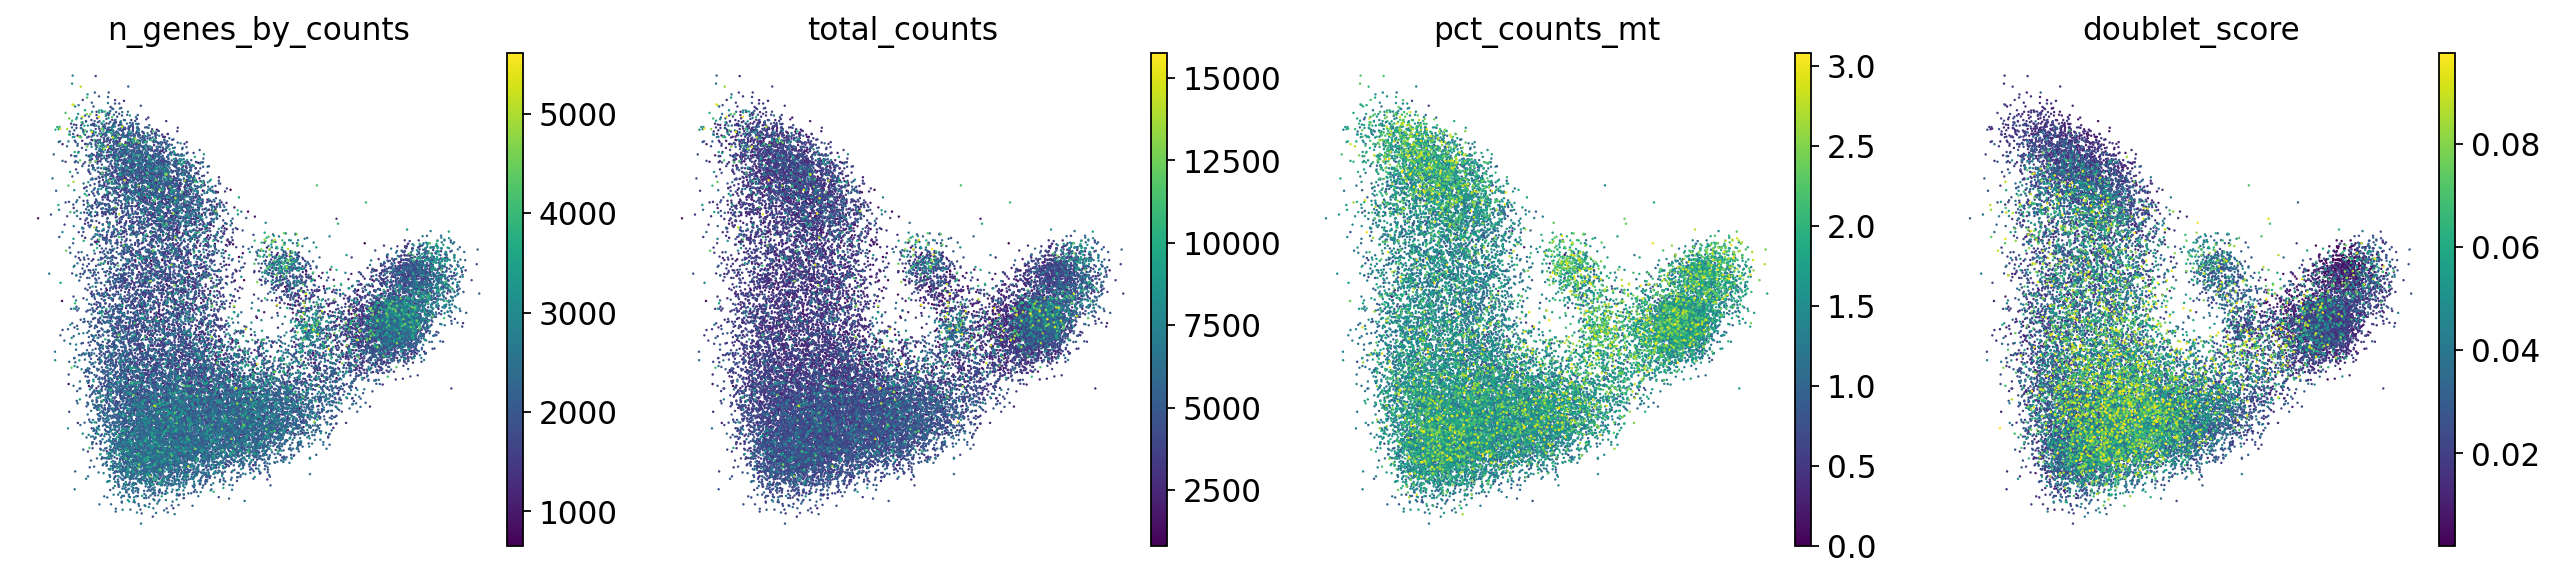

In [49]:
sc.pl.pca_scatter(adata, color=reqCols)

## kNN, clustering and UMAP

In [51]:
sc.pp.neighbors(adata, n_pcs=n_pcs)

In [54]:
sc.tl.leiden(adata, resolution=resolution)

## UMAP

In [56]:
sc.tl.umap(adata, min_dist=min_dist, spread=spread)

In [75]:
reqCols.extend(["leiden"])

In [76]:
reqCols

['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'leiden']

/home/jovyan/my-conda-envs/singlecell/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/jovyan/my-conda-envs/singlecell/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


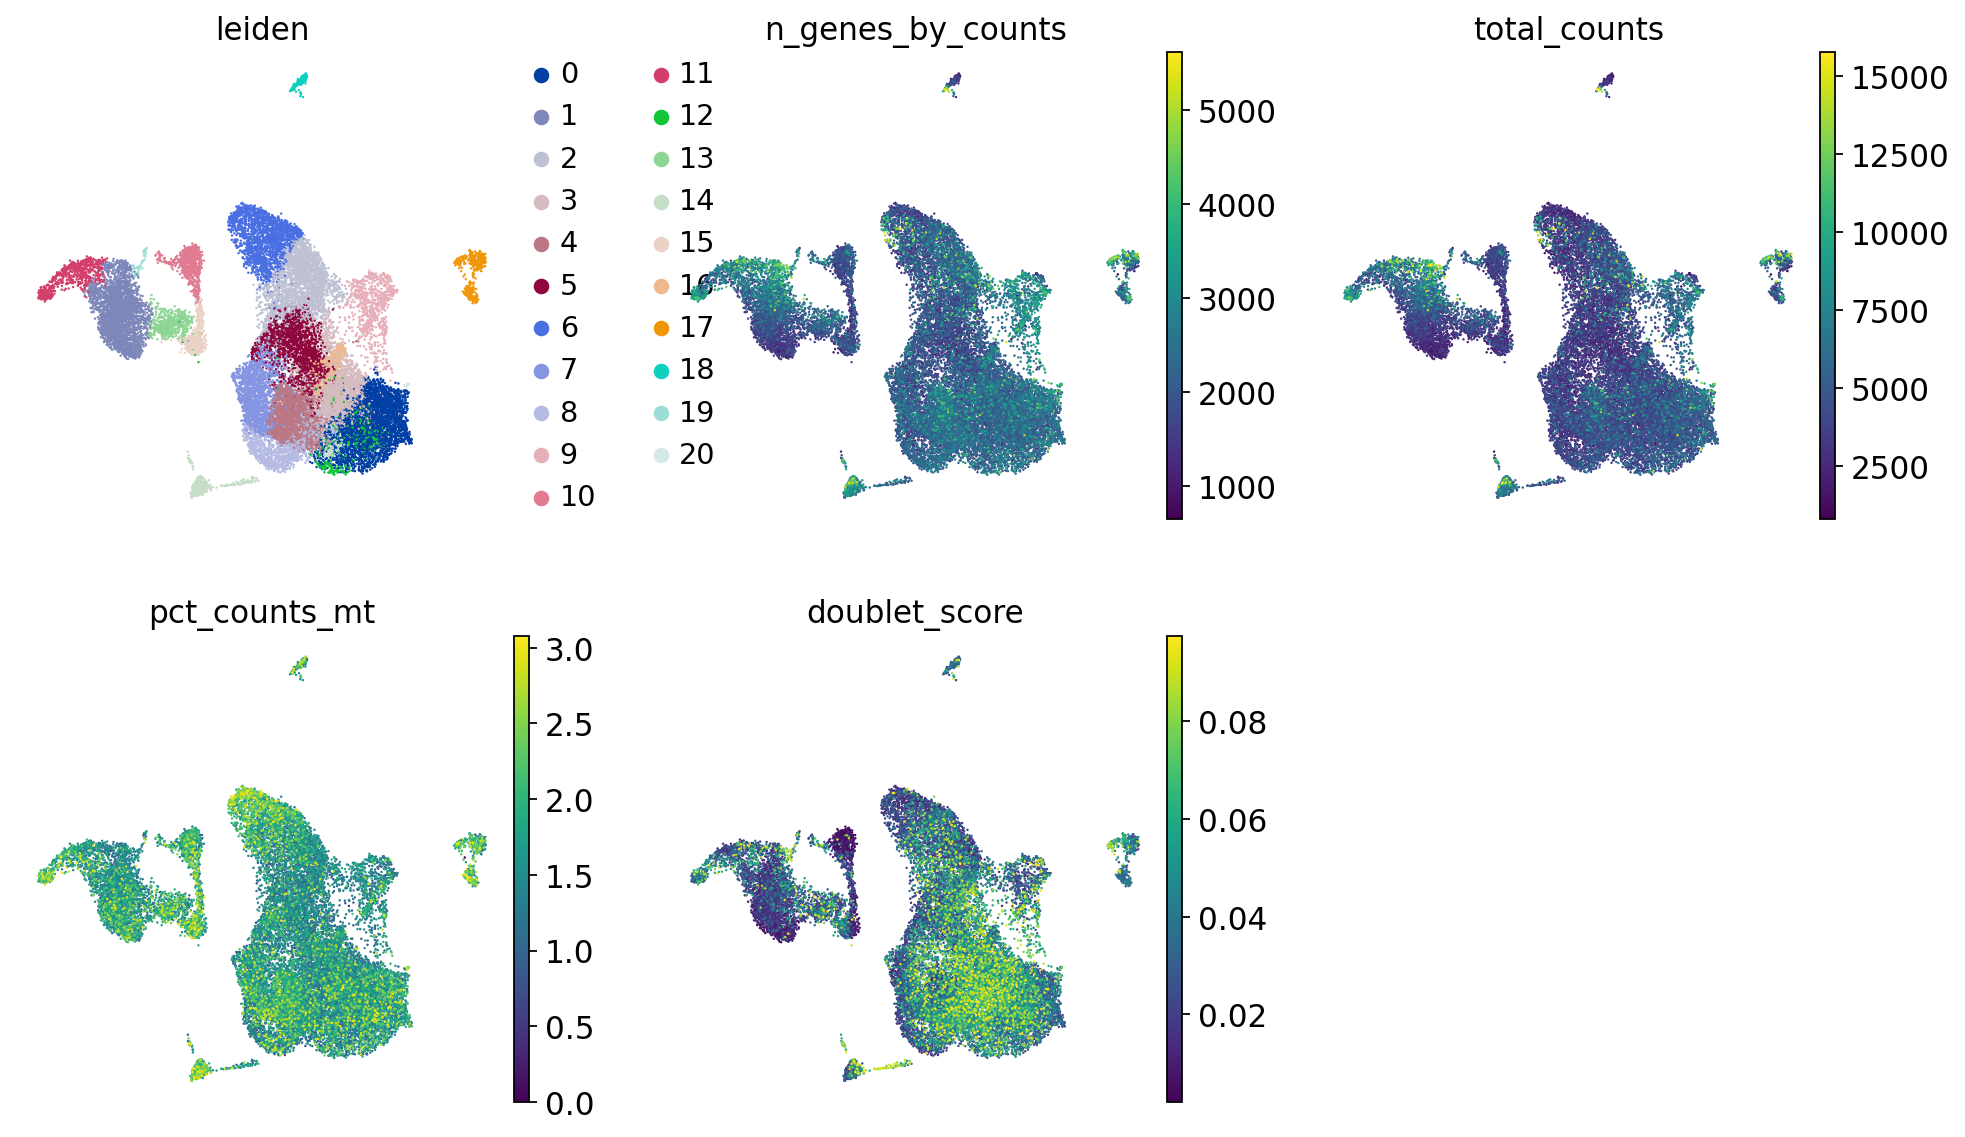

In [57]:
sc.pl.umap(adata, color=reqCols, ncols=3)

In [ ]:
adata.write_h5ad(os.path.join(outpt_folder, sample_name + sample_id + ".h5ad"))